# Modelo C

Autor: Andres Cordero

# Setup del cuaderno

In [42]:
import pandas as pd
from ydata_profiling import ProfileReport
from wordcloud import WordCloud
import matplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string, unicodedata
from num2words import num2words
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import inflect
matplotlib.use('Qt5Agg')
%matplotlib inline
import matplotlib.pyplot as plt
# import word tokenize
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Entendimiento de los datos

In [21]:
df_original = pd.read_csv(r'C:\Users\arisc\Trabajos\Universidad\10 Semestre\BI\BI_PROY1_2402\Proyecto 1\Etapa 1\Datasets\ODScat_345.csv', encoding='utf-8')
df_test_original = pd.read_excel(r'C:\Users\arisc\Trabajos\Universidad\10 Semestre\BI\BI_PROY1_2402\Proyecto 1\Etapa 1\Datasets\TestODScat_345.xlsx')
df_original.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


In [22]:
train, test = train_test_split(df_original, test_size=0.2, random_state=33)
train.head()

,Textos_espanol,sdg
1464,Estos atributos requeridos también se amplían ...,4
1721,"Law Cell, â€oeCircular no. El primero exige un...",4
1606,"En segundo lugar, si se quiere implementar con...",4
2492,"Sin embargo, si bien los créditos de contribuc...",5
2005,También es importante la sensibilización y edu...,5


## Calidad de los datos

Dimensiones de calidad de los datos:
+ Consistencia
+ Validez
+ Completitud
+ Unicidad

### Completitud

Bajo una inspección sencilla, parece no haber problemas de completitud en los datos

In [23]:
train['sdg'].value_counts()

sdg
5    1156
4    1086
3     997
Name: count, dtype: int64

In [24]:
# strip all values in the column
train['Textos_espanol'] = train['Textos_espanol'].str.strip()
# count all values in the column where the value is an empty string

train['Textos_espanol'].isnull().sum()

0

### Validez

Se identifican los siguietnes problemas de validez:
+ Hay un problema de codificación de los textos en el dataset, pues muchos caracteres que corresponden a vocales con tilde han sido reemplazados por caracteres no válidos.

In [25]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

train['Textos_espanol'] = train['Textos_espanol'].apply(fix_encoding)

In [26]:
train.head(5)

,Textos_espanol,sdg
1464,Estos atributos requeridos también se amplían ...,4
1721,"Law Cell, â€oeCircular no. El primero exige un...",4
1606,"En segundo lugar, si se quiere implementar con...",4
2492,"Sin embargo, si bien los créditos de contribuc...",5
2005,También es importante la sensibilización y edu...,5


### Consistencia

Algunas de las entradas de texto del dataset están rodeadas por comillas dobles, aunque no todas. Es posible que esto no introduzca problemas en el dataset. 

### Unicidad

En primera instancia, el dataset no tiene columnas que deban ser únicas siguiento algúna restricción de negocio. Bajo una inspección sencilla, parece no haber filas totalmente duplicadas.

In [27]:
train.duplicated().sum()

0

## Perfilamiento de los datos

Se aprovecha el paquete ydata-profiling para hacer un perfilamiento detallado del dataset. A partir de este reporte se destacan las siguientes conclusiones:
+ Variables: 2
+ Observaciones: 4049

|Variable|Tipo|
|--|--|
|Textos_espanol|Text|
|sdg|Categórica|

+ Se observa con ayuda del wordcloud que las palabras mas frecuentes en el dataset son stopwords que podrían ser eliminadas en el paso de procesamiento de datos. 


In [28]:
profile = ProfileReport(train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
def mostrar_grafico1(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

---------- Words for class: 4 ----------


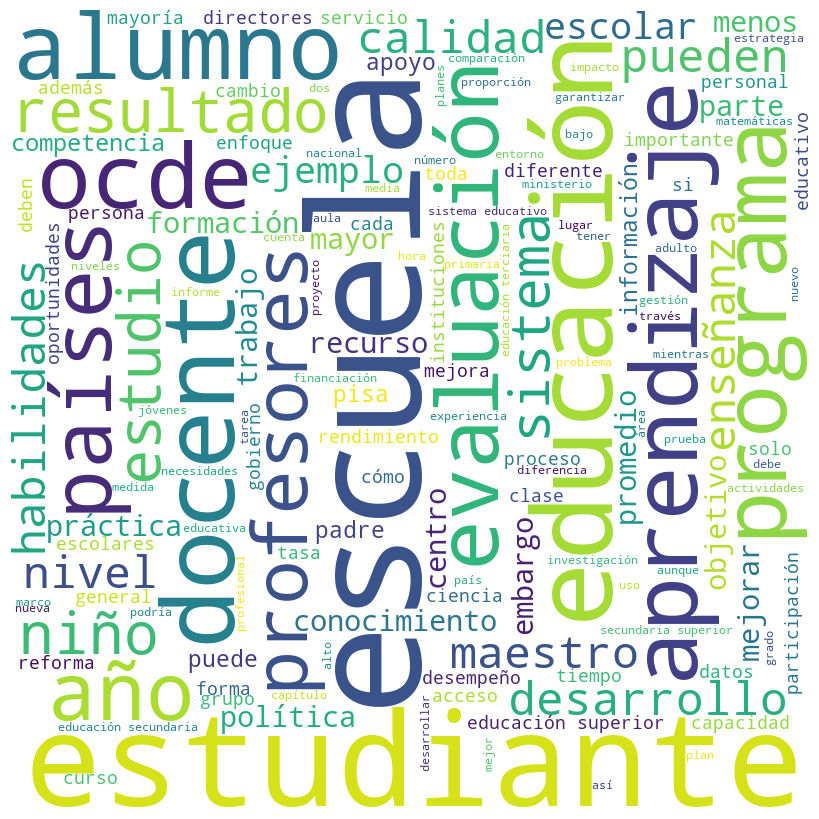

---------- Words for class: 5 ----------


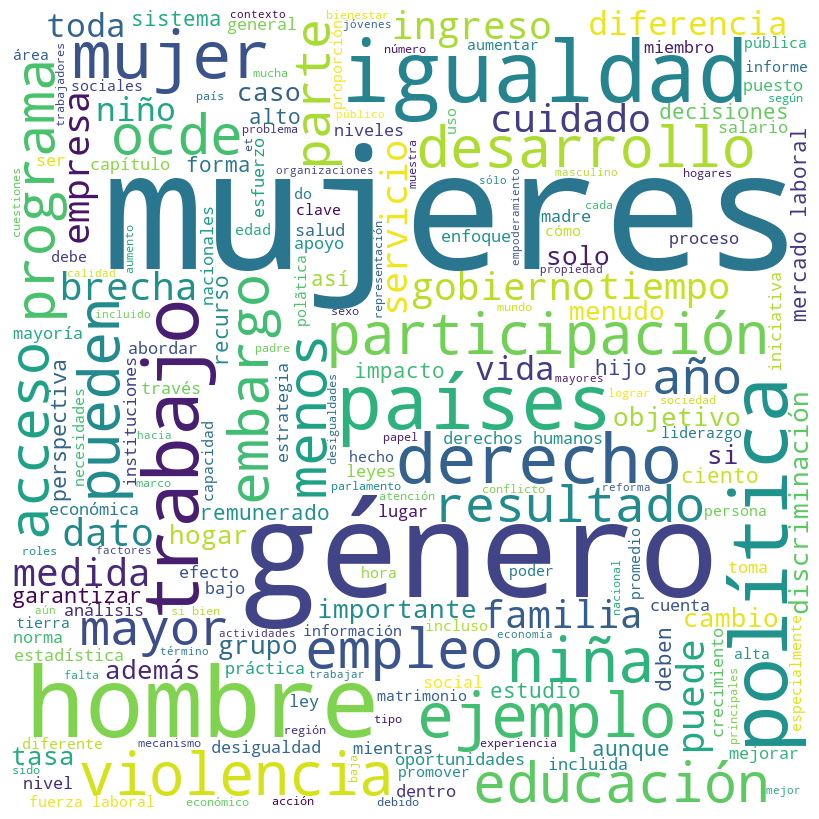

---------- Words for class: 3 ----------


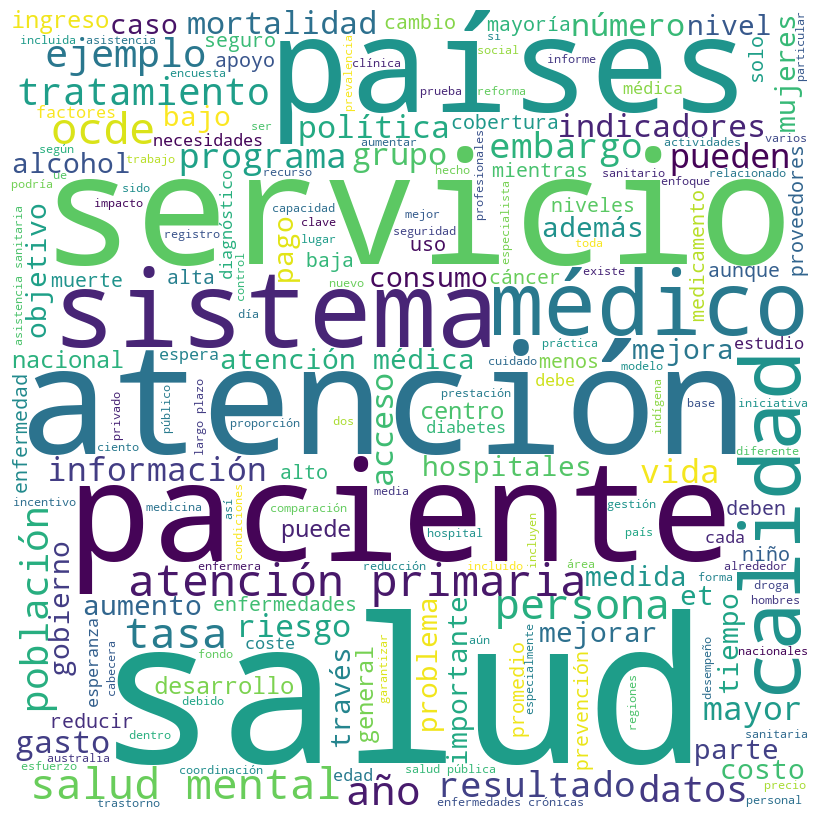

In [30]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))

for i in train['sdg'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico1(train.loc[train['sdg']==i,'Textos_espanol'], stopwords=stop_words)

In [19]:
train

,Textos_espanol,sdg
1464,Estos atributos requeridos también se amplían ...,4
1721,"Law Cell, â€oeCircular no. El primero exige un...",4
1606,"En segundo lugar, si se quiere implementar con...",4
2492,"Sin embargo, si bien los créditos de contribuc...",5
2005,También es importante la sensibilización y edu...,5
...,...,...
2706,Las mujeres migrantes mayores pueden enfrentar...,5
578,"Estos pueden basarse en la edad, el sexo o el ...",3
1752,Las rúbricas pretenden ayudar a los profesores...,4
2439,"A la inversa, la incapacidad de lograr un enfo...",5


# Preparación de los datos

In [31]:
X_train, y_train = train['Textos_espanol'], train['sdg'] 
display(X_train)
y_train

1464    Estos atributos requeridos también se amplían ...
1721    Law Cell, â€oeCircular no. El primero exige un...
1606    En segundo lugar, si se quiere implementar con...
2492    Sin embargo, si bien los créditos de contribuc...
2005    También es importante la sensibilización y edu...
                              ...                        
2706    Las mujeres migrantes mayores pueden enfrentar...
578     Estos pueden basarse en la edad, el sexo o el ...
1752    Las rúbricas pretenden ayudar a los profesores...
2439    A la inversa, la incapacidad de lograr un enfo...
3092    Las mujeres de los países de las regiones más ...
Name: Textos_espanol, Length: 3239, dtype: object

1464    4
1721    4
1606    4
2492    5
2005    5
       ..
2706    5
578     3
1752    4
2439    5
3092    5
Name: sdg, Length: 3239, dtype: int64

In [35]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lower(words: list[str]):
    return [word.lower() for word in words]

def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalnum()]

def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

def remove_numbers(words):
    new_words = []
    for word in words:
        if not word.isdigit(): 
            new_words.append(word)  
    return new_words

def preprocessing(words):
    words = remove_non_ascii(words)
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = remove_numbers(words)
    return words

In [36]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preprocessing) 
new_X_train.head()

1464    [atributos, requeridos, tambien, amplian, ocas...
1721    [law, cell, aoecircular, primero, exige, marco...
1606    [segundo, lugar, si, quiere, implementar, exit...
2492    [embargo, si, bien, creditos, contribucion, pu...
2005    [tambien, importante, sensibilizacion, educaci...
Name: Textos_espanol, dtype: object

In [41]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

new_X_train = new_X_train.apply(stem_and_lemmatize) 
new_X_train.head()

1464    [atribut, requer, tambi, ampli, ocasion, inclu...
1721    [law, cell, aoecircul, primer, exig, marc, leg...
1606    [segund, lug, si, quier, implement, exit, comp...
2492    [embarg, si, bien, credit, contribucion, pued,...
2005    [tambi, import, sensibiliz, educ, derech, huma...
Name: Textos_espanol, dtype: object

In [ ]:
# REVISAR DESDE AQUI
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(new_X_train['Textos_espanol'].apply(lambda x: ' '.join(x)))

# Mostrar resultados
print("Características TF-IDF:")
print(vectorizer.get_feature_names_out())
print("\nRepresentación TF-IDF:")
print(X_tfidf.toarray())